## 基于天气数据集的XGBoost分类实战
### 利用气象站提供的每日降雨数据，根据历史降雨数据来预测明天降雨的概率

### Step1:函数库导入

In [2]:
#基础函数库
import numpy as np
import pandas as pd

#绘图函数库
import matplotlib.pyplot as plt
import seaborn as sns

### Step2:数据读取/载入

In [3]:
!wget https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/7XGBoost/train.csv

--2023-07-07 06:16:52--  https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/7XGBoost/train.csv
Resolving tianchi-media.oss-cn-beijing.aliyuncs.com (tianchi-media.oss-cn-beijing.aliyuncs.com)... 59.110.185.93
Connecting to tianchi-media.oss-cn-beijing.aliyuncs.com (tianchi-media.oss-cn-beijing.aliyuncs.com)|59.110.185.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11476379 (11M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]  10.94M  1.58MB/s    in 13s     

2023-07-07 06:17:06 (889 KB/s) - ‘train.csv’ saved [11476379/11476379]



In [4]:
data=pd.read_csv('train.csv')

### Step3：数据信息简单查看

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106644 entries, 0 to 106643
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           106644 non-null  object 
 1   Location       106644 non-null  object 
 2   MinTemp        106183 non-null  float64
 3   MaxTemp        106413 non-null  float64
 4   Rainfall       105610 non-null  float64
 5   Evaporation    60974 non-null   float64
 6   Sunshine       55718 non-null   float64
 7   WindGustDir    99660 non-null   object 
 8   WindGustSpeed  99702 non-null   float64
 9   WindDir9am     99166 non-null   object 
 10  WindDir3pm     103788 non-null  object 
 11  WindSpeed9am   105643 non-null  float64
 12  WindSpeed3pm   104653 non-null  float64
 13  Humidity9am    105327 non-null  float64
 14  Humidity3pm    103932 non-null  float64
 15  Pressure9am    96107 non-null   float64
 16  Pressure3pm    96123 non-null   float64
 17  Cloud9am       66303 non-null

In [6]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2012/1/19,MountGinini,12.1,23.1,0.0,NaN,NaN,W,30.0,N,...,60.0,54.0,NaN,NaN,NaN,NaN,17.0,22.0,No,No
1,2015/4/13,Nhil,10.2,24.7,0.0,NaN,NaN,E,39.0,E,...,63.0,33.0,1021.9,1017.9,NaN,NaN,12.5,23.7,No,Yes
2,2010/8/5,Nuriootpa,-0.4,11.0,3.6,0.4,1.6,W,28.0,N,...,97.0,78.0,1025.9,1025.3,7.0,8.0,3.9,9.0,Yes,No
3,2013/3/18,Adelaide,13.2,22.6,0.0,15.4,11.0,SE,44.0,E,...,47.0,34.0,1025.0,1022.2,NaN,NaN,15.2,21.7,No,No
4,2011/2/16,Sale,14.1,28.6,0.0,6.6,6.7,E,28.0,NE,...,92.0,42.0,1018.0,1014.1,4.0,7.0,19.1,28.2,No,No


#### 我们发现数据集中存在缺失值
#### 缺失值处理方法：中位数填补、平均数填补

In [7]:
data=data.fillna(-1)

In [8]:
data.tail()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
106639,2011/5/23,Launceston,10.1,16.1,15.8,-1.0,-1.0,SE,31.0,NNW,...,99.0,86.0,999.2,995.2,-1.0,-1.0,13.0,15.6,Yes,Yes
106640,2014/12/9,GoldCoast,19.3,31.7,36.0,-1.0,-1.0,SE,80.0,NNW,...,75.0,76.0,1013.8,1010.0,-1.0,-1.0,26.0,25.8,Yes,Yes
106641,2014/10/7,Wollongong,17.5,22.2,1.2,-1.0,-1.0,WNW,65.0,WNW,...,61.0,56.0,1008.2,1008.2,-1.0,-1.0,17.8,21.4,Yes,No
106642,2012/1/16,Newcastle,17.6,27.0,3.0,-1.0,-1.0,-1,-1.0,NE,...,68.0,88.0,-1.0,-1.0,6.0,5.0,22.6,26.4,Yes,No
106643,2014/10/21,AliceSprings,16.3,37.9,0.0,14.2,12.2,ESE,41.0,NNE,...,8.0,6.0,1017.9,1014.0,0.0,1.0,32.2,35.7,No,No


特征<br>
1.Date日期 2.Location位置 3.MinTemp最低温度 4.MaxTemp最高温度 5.Rainfall降雨量 6.Evaporation蒸发量 7.Sunshine日照量 8.WindGustDir风力涡轮机

In [9]:
#查看训练集标签（RainTomorrow）的数量
pd.Series(data['RainTomorrow']).value_counts()

No     82786
Yes    23858
Name: RainTomorrow, dtype: int64

#### 负样本的数量远大于正样本的数量->数据不平衡问题

In [10]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000,106644.000000
mean,12.129147,23.183398,2.313912,2.704798,3.509008,37.305137,13.852200,18.265378,67.940353,50.104657,917.003689,914.995385,2.381231,2.285670,16.877842,21.257600
std,6.444358,7.208596,8.379145,4.519172,5.105696,16.585310,8.949659,9.118835,20.481579,22.136917,304.042528,303.120731,3.483751,3.419658,6.629811,7.549532
min,-8.500000,-4.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-7.200000,-5.400000
25%,7.500000,17.900000,0.000000,-1.000000,-1.000000,30.000000,7.000000,11.000000,56.000000,35.000000,1011.000000,1008.500000,-1.000000,-1.000000,12.200000,16.300000
50%,12.000000,22.600000,0.000000,1.600000,0.200000,37.000000,13.000000,17.000000,70.000000,51.000000,1016.700000,1014.200000,1.000000,1.000000,16.700000,20.900000
75%,16.800000,28.300000,0.600000,5.400000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.300000
max,31.900000,48.100000,268.600000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,39.400000,46.200000


#### Step4:可视化描述

In [11]:
#记录数字特征
numerical_features=[x for x in data.columns if data[x].dtype==np.float]
numerical_features

/tmp/ipykernel_28/3821842049.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numerical_features=[x for x in data.columns if data[x].dtype==np.float]


['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [12]:
#记录非数字特征
category_features=[x for x in data.columns if data[x].dtype!=np.float]
category_features

/tmp/ipykernel_28/2157002330.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  category_features=[x for x in data.columns if data[x].dtype!=np.float]


['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

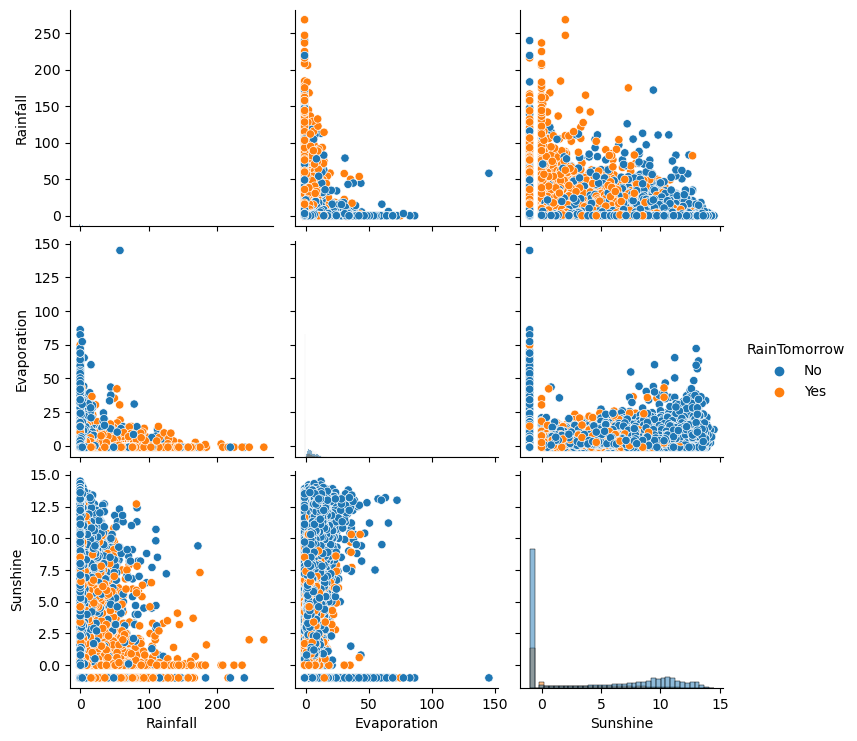

In [13]:
#选取三个特征与标签组合的散点可视化
sns.pairplot(data=data[['Rainfall','Evaporation','Sunshine']+['RainTomorrow']],diag_kind='hist',hue='RainTomorrow')
plt.show()

由上图可以看到，在2D情况下，不同的特征组合对于第二天下雨/不下雨的散点分布<br>
Sunshine与其他特征的组合相比于其他特征相结合的组合更加具有区分力（容易将RainTomorrow的Yes与No划分开）

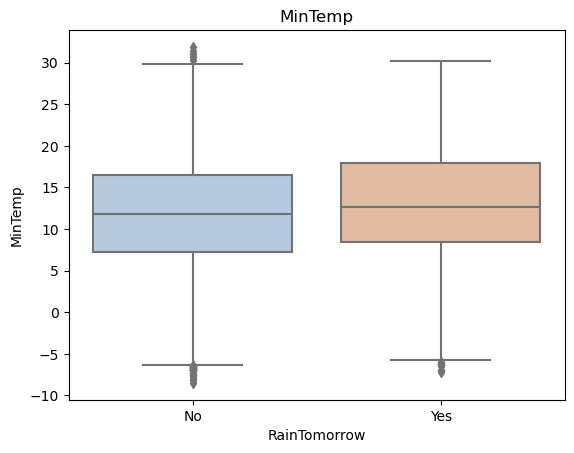

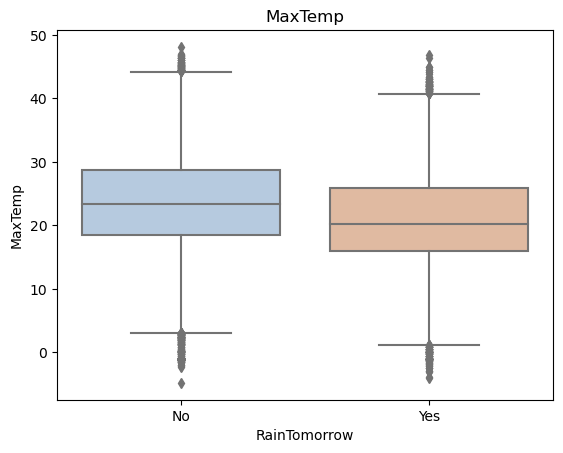

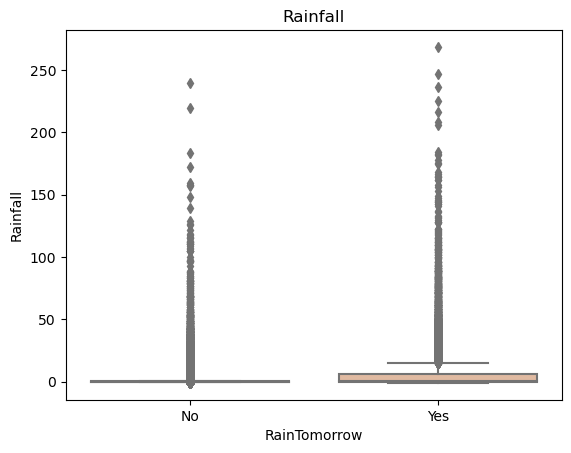

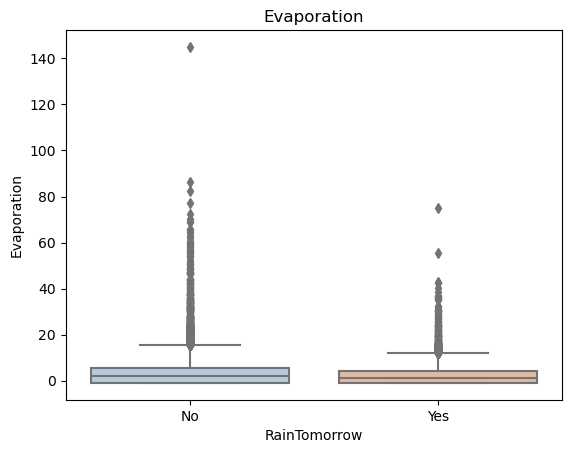

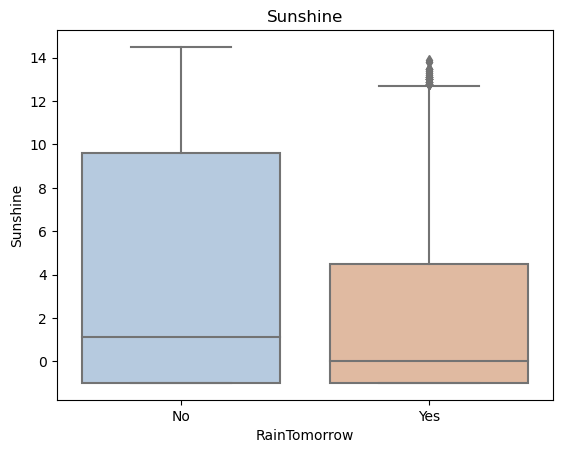

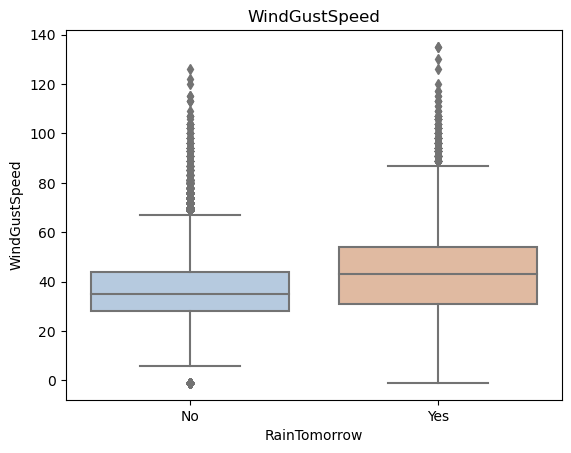

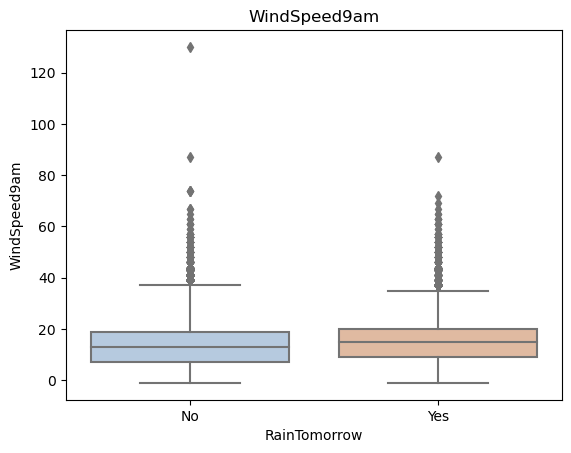

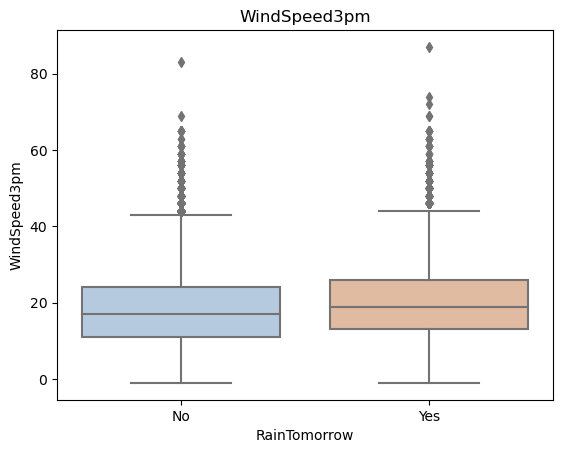

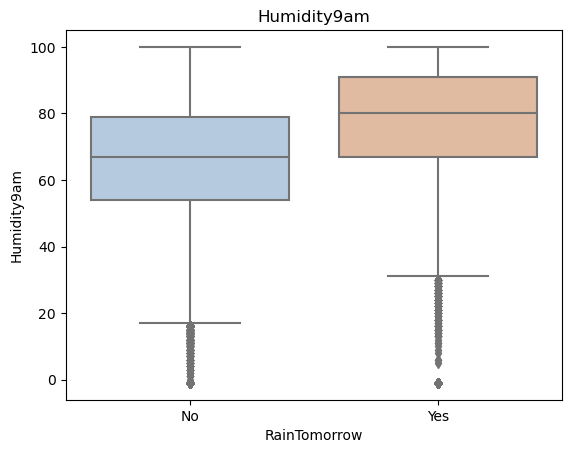

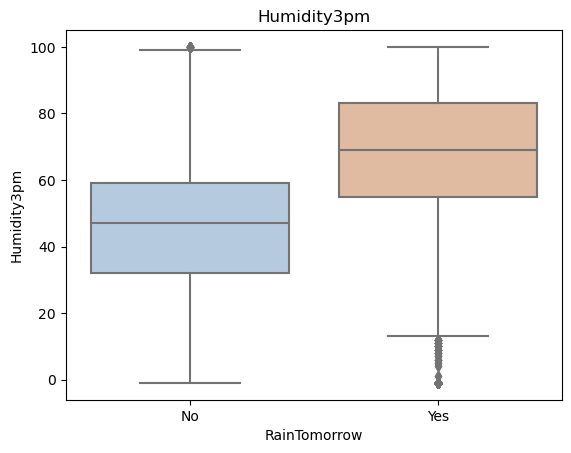

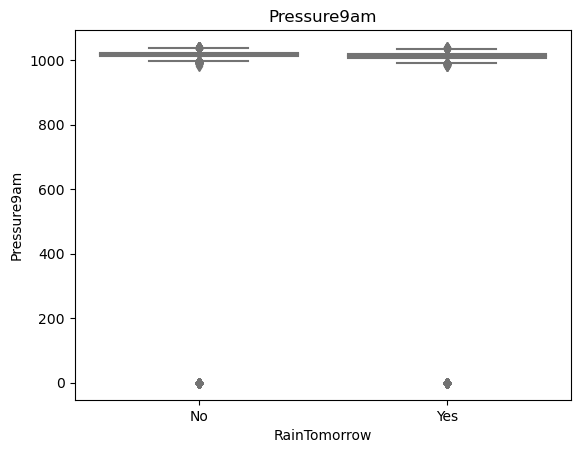

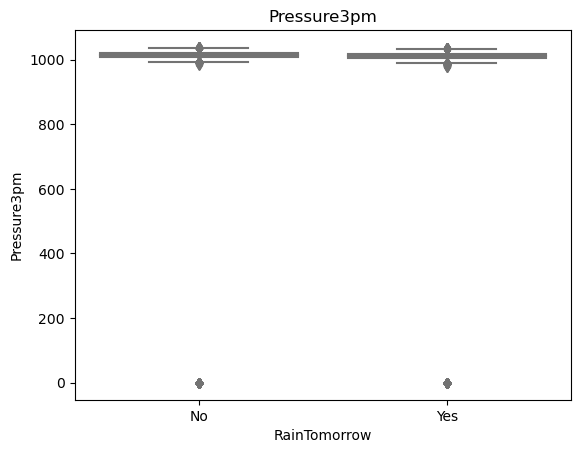

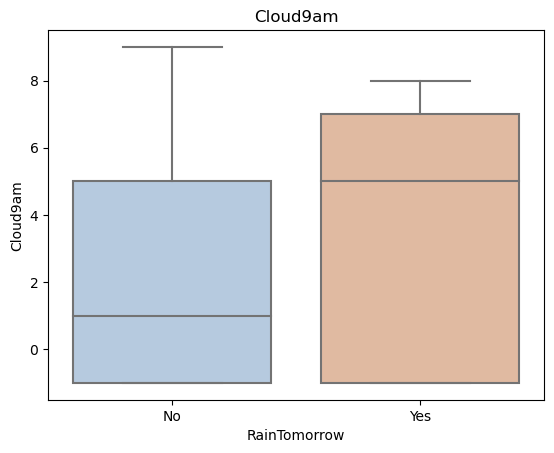

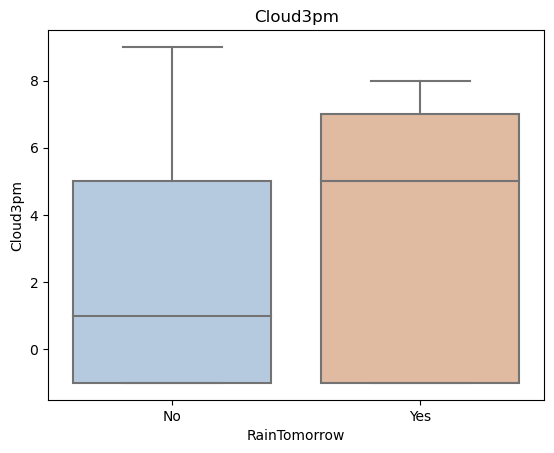

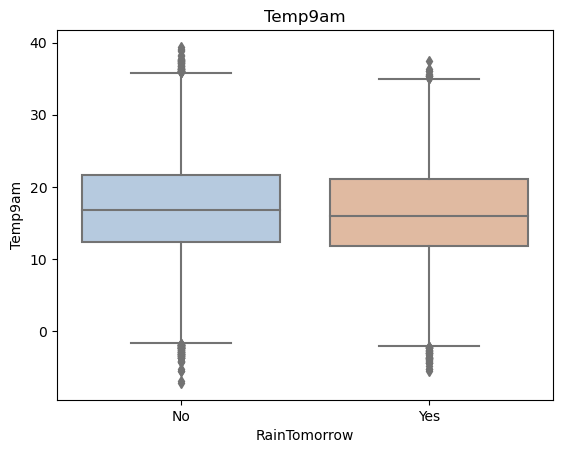

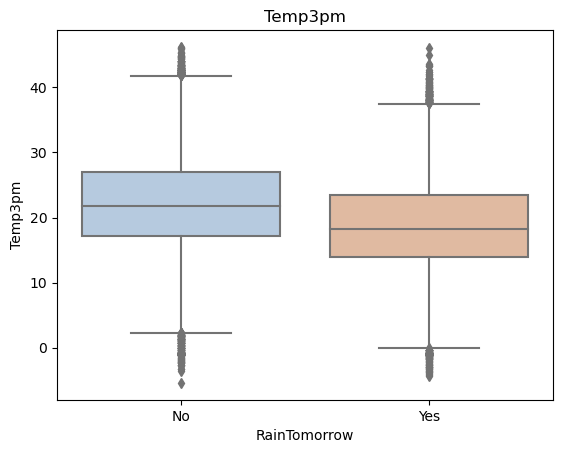

In [14]:
#箱型图的绘制
for col in data[numerical_features].columns:
    if col!='RainTomorrow':
        sns.boxplot(x='RainTomorrow',y=col,saturation=0.5,palette='pastel',data=data)
        #x='RainTomorrow'：指定箱线图的x轴数据为"RainTomorrow"，即根据"RainTomorrow"这一列的取值进行分组。
        #y=col：指定箱线图的y轴数据为变量col，即绘制的箱线图的具体数值数据。
        #saturation=0.5：设置颜色的饱和度为0.5。
        #palette='pastel'：使用'pastel'调色板来设置箱线图的颜色。
        #data=data：指定数据源为名为data的数据集。
        plt.title(col)
        plt.show()

我们可以发现Sunshine,Humidity3pm,Cloud9am,Cloud3pm的区分能力较强

In [15]:
#对非数字特征进行处理
tlog={} #记录第二天会下雨
for i in category_features:
    tlog[i]=data[data['RainTomorrow']=='Yes'][i].value_counts()
flog={} #记录第二天不会下雨
for i in category_features:
    flog[i]=data[data['RainTomorrow']=='No'][i].value_counts()
print(tlog)

{'Date': 2010/9/3      29
2009/6/2      27
2012/7/10     27
2015/9/2      27
2013/6/12     26
              ..
2008/10/5      1
2015/10/6      1
2010/1/15      1
2007/11/30     1
2008/9/16      1
Name: Date, Length: 3163, dtype: int64, 'Location': Portland            818
Walpole             722
Cairns              700
MountGambier        692
Dartmoor            679
CoffsHarbour        677
NorfolkIsland       669
Albany              665
Witchcliffe         663
Darwin              645
Sydney              642
MountGinini         623
NorahHead           607
Ballarat            597
Hobart              579
SydneyAirport       573
GoldCoast           569
Watsonia            567
Newcastle           555
Wollongong          542
Williamtown         532
Brisbane            529
Adelaide            513
Launceston          506
MelbourneAirport    493
Sale                479
Melbourne           478
Canberra            475
Perth               474
Albury              454
Penrith             451
Nuriootp

查看Location与RainTomorrow之间的关系

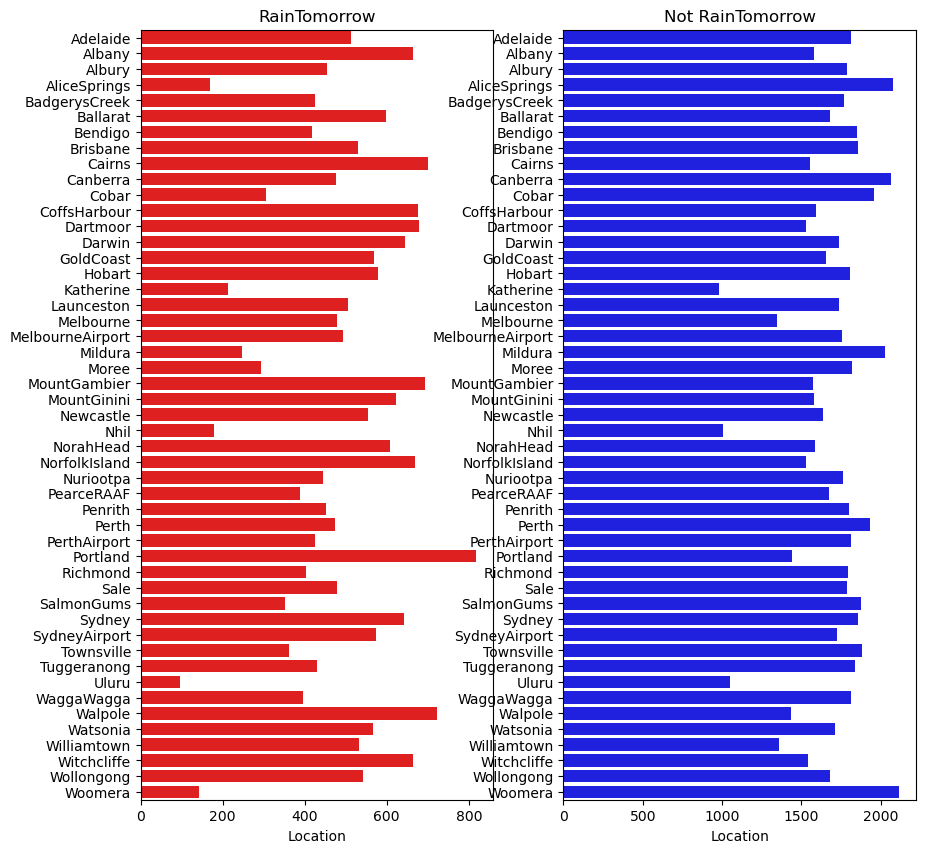

In [16]:
plt.figure(figsize=(10,10)) #创建一个图形，并且设置宽度和高度都为10英寸
plt.subplot(1,2,1) #创建一个1行2列的子图，我们现在绘制第一个图
plt.title('RainTomorrow')
sns.barplot(x=pd.DataFrame(tlog['Location']).sort_index()['Location'],y=pd.DataFrame(tlog['Location']).sort_index().index,color='red')
#x为柱状图的x轴数据，sort_index用于排序，我们使用排序后的索引即sort_index().index
plt.subplot(1,2,2)
plt.title('Not RainTomorrow')
sns.barplot(x=pd.DataFrame(flog['Location']).sort_index()['Location'],y=pd.DataFrame(flog['Location']).sort_index().index,color='blue')
plt.show() #显示图形

不同地区的降雨情况差别很大，有些地方更容易降雨

查看RainToday与RainTomorrow之间的关系

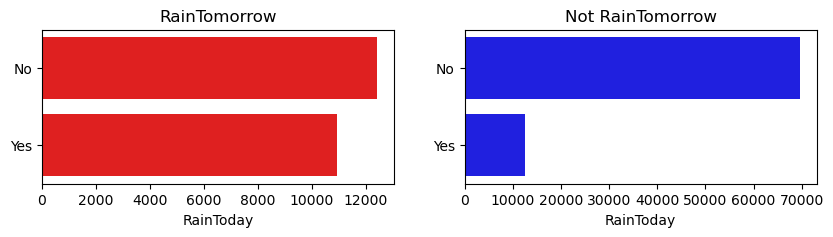

In [17]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.title('RainTomorrow')
#sort_index().index用于获取排序后的数据的索引
#柱状图中，x轴代表分类变量，y轴代表该分类变量对应的数值
#pd.DataFrame(tlog['Location']).sort_index()['Location']用于获取'tlog'数据中'Location'列的值，并进行排序。但排序后的结果仅包含排序后的数据值，而不包含原始数据的索引。
sns.barplot(x=pd.DataFrame(tlog['RainToday'][:2]).sort_index()['RainToday'],y=pd.DataFrame(tlog['RainToday'][:2]).sort_index().index,color='red')
#通过使用sort_index().index，我们获取了排序后的数据的索引，并将其作为柱状图的x轴值，以确保柱状图的x轴标签与原始数据的索引一致。
plt.subplot(1,2,2)
plt.title('Not RainTomorrow')
sns.barplot(x=pd.DataFrame(flog['RainToday'][:2]).sort_index()['RainToday'],y=pd.DataFrame(flog['RainToday'][:2]).sort_index().index,color='blue')
plt.show()

今天下雨明天不一定下雨，但今天不下雨，第二天大概率也不下雨。

### Step5:对离散变量进行编码

XGBoost无法处理字符串类型的数据，我们需要一些方法讲字符串数据转化为数据。<br>
一种最简单的方法是把所有的相同类别的特征编码成同一个值，例如女=0，男=1，狗狗=2，所以最后编码的特征值是在 
[
0
,
特
征
数
量
−
1
]
 之间的整数。除此之外，还有独热编码、求和编码、留一法编码等等方法可以获得更好的效果。

In [18]:
#所有的相同特征编码为同一个值
def get_mapfunction(x):
    mapp=dict(zip(x.unique().tolist(),range(len(x.unique().tolist()))))
    #unique()用于获取数组或者序列中唯一值的函数，并且以原始顺序排列
    #tolist()用于将数组、列表或者其他的可迭代对象转换为Python列表的函数
    #dict()用于将键值转换为字典对象
    #zip()用于将多个可迭代对象逐个元素的配对组合
    def mapfunction(y):
        if y in mapp:
            return mapp[y]
        else:
            return -1
    return mapfunction
for i in category_features:
    data[i]=data[i].apply(get_mapfunction(data[i]))
data.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,0,12.1,23.1,0.0,-1.0,-1.0,0,30.0,0,...,60.0,54.0,-1.0,-1.0,-1.0,-1.0,17.0,22.0,0,0
1,1,1,10.2,24.7,0.0,-1.0,-1.0,1,39.0,1,...,63.0,33.0,1021.9,1017.9,-1.0,-1.0,12.5,23.7,0,1
2,2,2,-0.4,11.0,3.6,0.4,1.6,0,28.0,0,...,97.0,78.0,1025.9,1025.3,7.0,8.0,3.9,9.0,1,0


**ZIP函数的应用** <br>
例子：<br>
list1 = [1, 2, 3] <br>
list2 = ['a', 'b', 'c'] <br>
list3 = ['x', 'y', 'z'] <br>

##### #使用zip函数配对组合列表
zipped = zip(list1, list2, list3)

##### #打印配对结果
for item in zipped:<br>
    print(item)

输出：<br>
(1, 'a', 'x')<br>
(2, 'b', 'y')<br>
(3, 'c', 'z')<br>


In [19]:
#编码后的字符串特征值变为数字
data['Location'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

### Step6：利用 XGBoost 进行训练与预测

In [20]:
#将数据集划分为训练集和测试集，并且在训练集上训练模型，在测试集上验证模型性能
from sklearn.model_selection import train_test_split

#选择其类别为0和1的样本
data_target_part=data['RainTomorrow']
data_features_part=data[[x for x in data.columns if x!='RainTomorrow']]

#划分数据
x_train,x_test,y_train,y_test=train_test_split(data_features_part,data_target_part,test_size=0.2,random_state=2020)

x_train

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
98173,2766,29,6.5,28.8,0.0,-1.0,-1.0,2,39.0,2,...,7.0,61.0,29.0,-1.0,-1.0,-1.0,-1.0,19.2,27.7,0
33154,1196,40,20.6,27.5,1.4,-1.0,-1.0,15,35.0,5,...,26.0,99.0,91.0,1003.2,1001.3,-1.0,-1.0,24.2,24.3,1
79386,2964,13,5.6,11.8,0.8,-1.0,-1.0,13,78.0,13,...,30.0,84.0,76.0,1000.7,996.5,7.0,8.0,5.8,9.7,0
96578,3052,38,0.8,14.4,0.0,-1.0,-1.0,5,33.0,4,...,19.0,98.0,45.0,1017.8,1013.5,-1.0,-1.0,5.4,13.7,0
73098,44,28,17.4,24.7,0.0,5.4,8.7,15,41.0,16,...,28.0,48.0,44.0,1034.3,1029.6,7.0,5.0,20.3,23.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,1655,17,24.0,30.3,15.4,4.2,2.0,10,41.0,13,...,24.0,81.0,72.0,1008.3,1005.5,7.0,7.0,27.1,28.2,1
44739,1552,38,10.5,22.2,0.0,-1.0,-1.0,5,15.0,4,...,2.0,73.0,54.0,1030.7,1027.2,-1.0,-1.0,16.3,20.6,0
40259,1611,26,6.0,10.7,0.0,1.4,0.3,2,31.0,0,...,13.0,79.0,76.0,1029.2,1029.3,-1.0,-1.0,8.3,10.1,0
61832,1415,33,16.9,23.0,9.4,-1.0,-1.0,8,24.0,14,...,4.0,94.0,76.0,-1.0,-1.0,-1.0,-1.0,18.7,22.1,1


In [21]:
y_train

98173    0
33154    0
79386    1
96578    0
73098    0
        ..
18523    0
44739    0
40259    0
61832    1
41824    0
Name: RainTomorrow, Length: 85315, dtype: int64

In [22]:
#导入XGBoost模型
from xgboost.sklearn import XGBClassifier
#定义XGBoost模型
clf=XGBClassifier()
#在训练集上训练XGBoost模型
clf.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

The accuracy of the XGBClassifier is: 0.8982476703979371
The accuracy of the XGBClassifier is: 0.8575179333302076
The confusion matrix result:
 [[15656  2142]
 [  897  2634]]


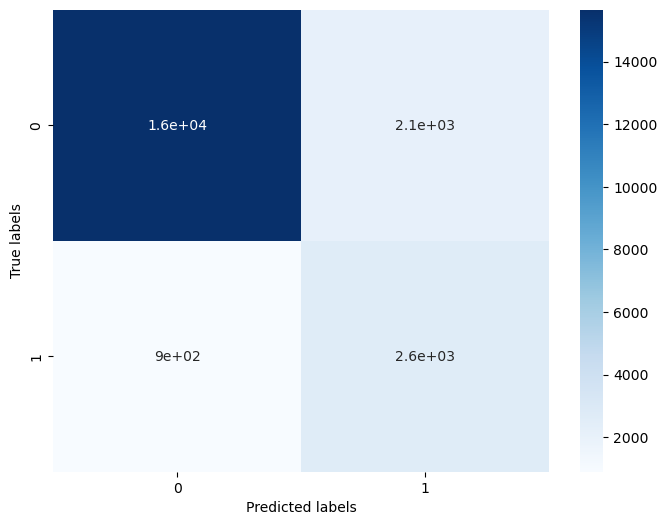

In [23]:
#在训练集和测试集上分别利用训练好的模型进行预测
train_predict=clf.predict(x_train)
test_predict=clf.predict(x_test)
from sklearn import metrics

#利用accuracy【预测正确的样本数目占据总预测样本数目的比例】评估模型效果
print('The accuracy of the XGBClassifier is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the XGBClassifier is:',metrics.accuracy_score(y_test,test_predict))

#查看混淆矩阵（预测值和真实值的各类情况统计矩阵）
confusion_matrix_result=metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

#利用热力图对结果进行可视化
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

总共有15759+2306个样本预测正确，2470+794个样本预测错误

### Step7: 利用 XGBoost 进行特征选择

XGBoost的特征选择属于特征选择中的嵌入式方法，在XGboost中可以用属性feature_importances_去查看特征的重要度。

In [24]:
?sns.barplot

Signature:
sns.barplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    estimator='mean',
    errorbar=('ci', 95),
    n_boot=1000,
    units=None,
    seed=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    errcolor='.26',
    errwidth=None,
    capsize=None,
    dodge=True,
    ci='deprecated',
    ax=None,
    **kwargs,
)
Docstring:
Show point estimates and errors as rectangular bars.

A bar plot represents an estimate of central tendency for a numeric
variable with the height of each rectangle and provides some indication of
the uncertainty around that estimate using error bars. Bar plots include 0
in the quantitative axis range, and they are a good choice when 0 is a
meaningful value for the quantitative variable, and you want to make
comparisons against it.

For datasets where 0 is not a meaningful value, a point plot will allow you
to focus on differences between levels of one or mo

<Axes: >

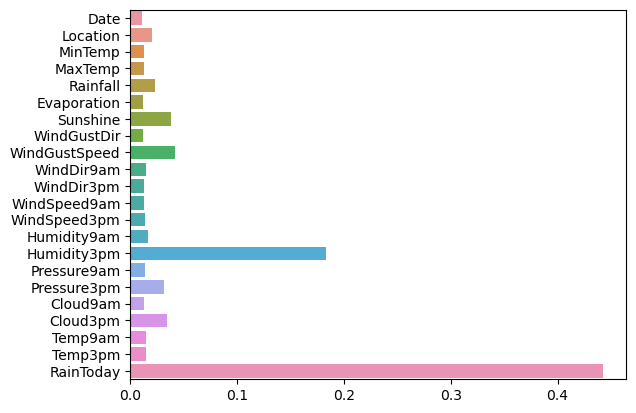

In [25]:
sns.barplot(y=data_features_part.columns,x=clf.feature_importances_)

显然下午3点的湿度与今天是否下雨是决定第二天是否下雨的最重要的因素

使用XGBoost中的下列重要属性来评估特征的重要性。

* weight:是以特征用到的次数来评价
* gain:当利用特征做划分的时候的评价基尼指数
* cover:利用一个覆盖样本的指标二阶导数（具体原理不清楚有待探究）平均值来划分。
* total_gain:总基尼指数
* total_cover:总覆盖

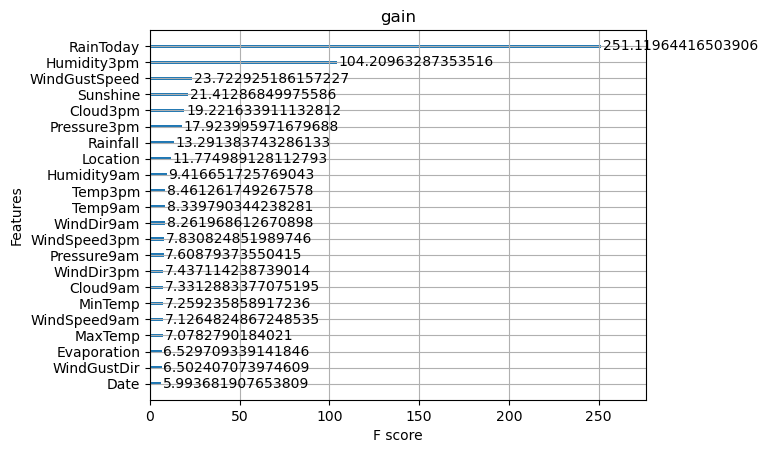

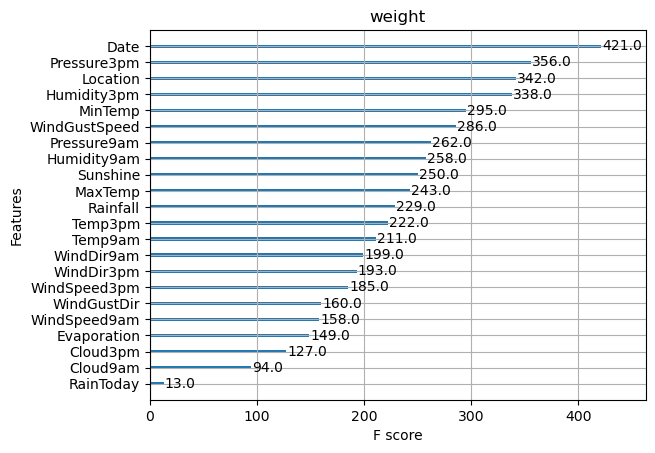

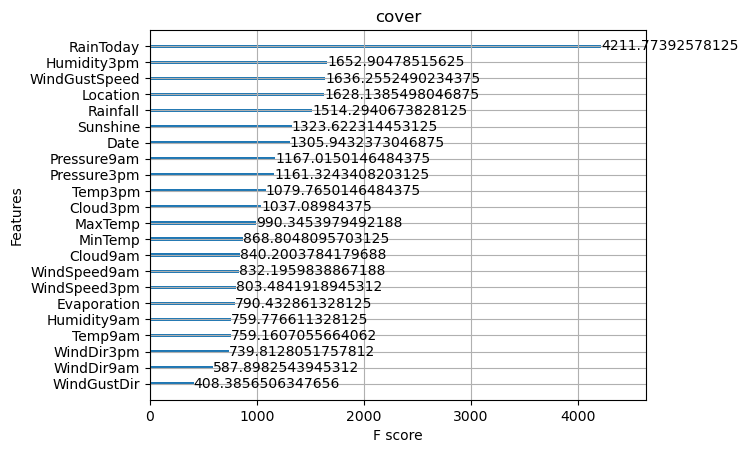

acc= 0.8575179333302076


In [26]:
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

def estimate(model,data):
    ax1=plot_importance(model,importance_type='gain')
    ax1.set_title('gain')
    ax2=plot_importance(model,importance_type='weight')
    ax2.set_title('weight')
    ax3=plot_importance(model,importance_type='cover')
    ax3.set_title('cover')
    plt.show()
def classes(data,label,test):
    model=XGBClassifier()
    model.fit(data,label)
    ans=model.predict(test)
    estimate(model,data)
    return ans

ans=classes(x_train,y_train,x_test)
pre=accuracy_score(y_test,ans)
print('acc=',accuracy_score(y_test,ans))

### Step8: 通过调整参数获得更好的效果

XGBoost中包括但不限于下列对模型影响较大的参数： <br>

* learning_rate: 有时也叫作eta，系统默认值为0.3。每一步迭代的步长，很重要。太大了运行准确率不高，太小了运行速度慢。<br>
* subsample：系统默认为1。这个参数控制对于每棵树，随机采样的比例。减小这个参数的值，算法会更加保守，避免过拟合, 取值范围零到一。<br>
* colsample_bytree：系统默认值为1。我们一般设置成0.8左右。用来控制每棵随机采样的列数的占比(每一列是一个特征)。<br>
* max_depth： 系统默认值为6，我们常用3-10之间的数字。这个值为树的最大深度。这个值是用来控制过拟合的。max_depth越大，模型学习的更加具体。<br>

调节模型参数的方法有**贪心算法、网格调参、贝叶斯调参**等。这里我们采用**网格调参**，它的基本思想是穷举搜索：在所有候选的参数选择中，通过循环遍历，尝试每一种可能性，表现最好的参数就是最终的结果

In [27]:
#从sklearn库中导入网格调参函数
from sklearn.model_selection import GridSearchCV

#定义参数取值范围
learning_rate=[0.1,0.3,0.6]
subsample=[0.8,0.9]
colsample_bytree=[0.6,0.8]
max_depth=[3,5,8]

parameters={'learning_rate':learning_rate,
           'subsample':subsample,
           'colsample_bytree':colsample_bytree,
           'max_depth':max_depth}
model=XGBClassifier(n_estimators=50)

#进行网格搜索
clf=GridSearchCV(model,parameters,cv=3,scoring='accuracy',verbose=1,n_jobs=-1)
clf=clf.fit(x_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [28]:
#网格搜索后最好的参数为
clf.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.3,
 'max_depth': 8,
 'subsample': 0.9}

The accuracy of the XGBoost Classifier is: 0.9414522651350876
The accuracy of the XGBoost Classifier is: 0.8569553190491819
The confusion matrix result:
 [[15614  2112]
 [  939  2664]]


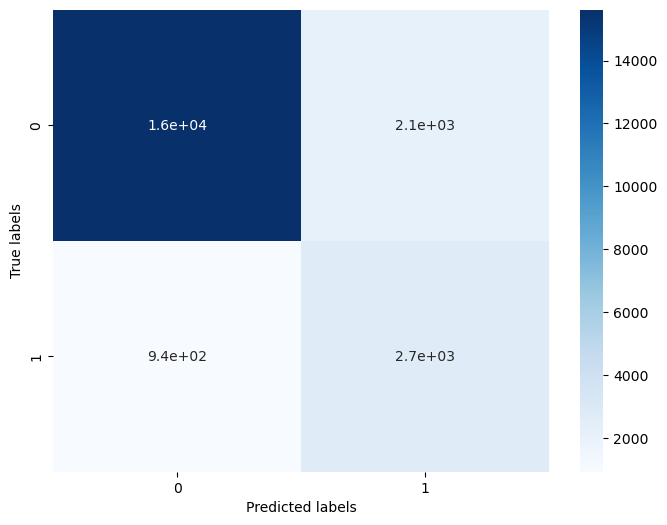

In [31]:
#在训练集和测试集上利用训练好的模型参数进行预测

#定义带参数的XGBoost模型
clf=XGBClassifier(colsample_bytree=0.6,learning_rate=0.3,max_depth=8,subsample=0.9)
#在训练集上训练XGBoost模型
clf.fit(x_train,y_train)

train_predict=clf.predict(x_train)
test_predict=clf.predict(x_test)

#利用accuracy评估模型效果
print('The accuracy of the XGBoost Classifier is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the XGBoost Classifier is:',metrics.accuracy_score(y_test,test_predict))

#查看混淆矩阵
confusion_matrix_result=metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

#利用热力图对结果可视化
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

$$
\require{AMsmath}
$$

## XGBoost的原理

XGBoost（eXtreme Gradient Boosting）是一种基于梯度提升树（Gradient Boosting Decision Trees）的机器学习算法，它在各种预测建模任务中表现出色。它采用了一种自适应的、基于梯度的提升策略，通过迭代地训练一系列的弱分类器（决策树），最终形成一个强大的集成模型。

XGBoost的核心原理如下：

1. **目标函数（Objective Function）**

   XGBoost通过定义一个目标函数来衡量模型的拟合程度和复杂度。它将目标函数分解为两个部分：数据的损失函数（Loss Function）和正则化项（Regularization Term）。

   目标函数的一般形式如下：<br>
   $$
   \text{Objective} = \text{Loss Function} + \text{Regularization Term}
   $$

   其中，损失函数度量了模型预测值与真实值之间的差异，而正则化项惩罚模型的复杂度，以防止过拟合。

2. **提升树（Boosting Trees）**

   XGBoost使用提升树算法，通过迭代地训练弱分类器（决策树），逐步改进模型的预测能力。

   在每次迭代中，XGBoost使用梯度提升算法来逐步优化模型。它首先计算当前模型对训练数据的预测值，然后计算残差（预测值与真实值之间的差异）。接下来，它训练一个新的弱分类器来预测残差，并将其添加到模型中。通过迭代这个过程，每个新的弱分类器都在之前弱分类器的基础上进行改进，最终形成一个强大的集成模型。

3. **正则化（Regularization）**

   为了控制模型的复杂度并防止过拟合，XGBoost引入了正则化项。正则化项在目标函数中，以惩罚模型中的复杂性。

   正则化项的一般形式如下：<br>
   $$
   \text{Regularization Term} = \lambda \sum_{j=1}^{J} \Omega(f_j)
   $$

   其中，$\Omega(f_j)$ 是决策树$f_j$ 的复杂度，$\lambda$ 是正则化参数，控制着正则化的强度。

4. **树结构的构建**

   XGBoost使用贪婪算法来构建树结构，即每次迭代时只考虑单个节点的分裂。

   在每次分裂中，XGBoost通过计算分裂增益（Split Gain）来选择最佳的分裂点。分裂增益是基于目标函数的优化准则，用于选择使目标函数下降最大化的分裂。

   为了控制树的复杂度，XGBoost还引入了叶子节点的权重约束。它根据树的深度和叶子节点的权重来限制树的生长。

5. **预测和优化**

   在模型训练完成后，XGBoost可以用于预测新样本的目标变量。

   对于回归问题，XGBoost通过将新样本传递到每棵树中，并对树的预测结果进行加权平均来计算最终预测值。

   对于二分类问题，XGBoost使用sigmoid函数将每棵树的预测结果转化为概率，然后对概率进行加权平均。

   对于多分类问题，XGBoost使用softmax函数将每棵树的预测结果转化为类别概率，然后对概率进行加权平均。


## XGBoost的重要参数

XGBoost具有许多重要的参数，可以用来调整模型的性能和行为。以下是一些常用的XGBoost参数：

1. `n_estimators`：弱分类器的数量。默认值为100。

2. `max_depth`：每棵树的最大深度。默认值为6。

3. `learning_rate`：每个弱分类器的学习率。默认值为0.3。

4. `subsample`：用于训练每个弱分类器的样本的子样本比例。默认值为1（使用所有样本）。

5. `colsample_bytree`：每个弱分类器使用的特征的子集比例。默认值为1（使用所有特征）。

6. `gamma`：分裂节点时所需的最小损失减少量。默认值为0。

7. `reg_lambda`：L2正则化项的权重。默认值为1。

8. `reg_alpha`：L1正则化项的权重。默认值为0。

9. `min_child_weight`：每个叶子节点所需的最小样本权重总和。默认值为1。

这些参数只是XGBoost的一部分，还有其他许多参数可供调整。调整这些参数可以影响模型的性能、过拟合程度和训练速度。

了解和调整这些参数可以帮助您优化XGBoost模型的性能和效果。请注意，最佳参数值取决于具体的问题和数据集，因此建议进行参数调优和交叉验证来找到最佳的参数组合。

## 特征选择的方法

在机器学习任务中，选择合适的特征对于模型性能的提升至关重要。以下是一些常用的特征选择方法：

1. **过滤式方法（Filter Methods）**：这些方法根据特征的统计属性或相关性进行选择。常用的过滤式方法包括皮尔逊相关系数、卡方检验、信息增益等。

2. **包裹式方法（Wrapper Methods）**：这些方法根据模型的性能来评估特征的重要性。它们通过迭代地选择一组特征，并使用模型来评估每个特征子集的性能。常用的包裹式方法包括递归特征消除（Recursive Feature Elimination）和正向选择（Forward Selection）等。

3. **嵌入式方法（Embedded Methods）**：这些方法将特征选择作为模型训练的一部分，通过在训练过程中自动选择重要的特征。嵌入式方法常用于具有内置特征选择功能的模型，如L1正则化的线性回归和决策树等。

4. **降维方法（Dimensionality Reduction Methods）**：这些方法通过将原始特征空间映射到一个较低维度的特征空间来选择特征。常用的降维方法包括主成分分析（Principal Component Analysis）和线性判别分析（Linear Discriminant Analysis）等。

选择合适的特征选择方法取决于问题的性质、数据集的规模和特征的属性。通常建议尝试多种方法，并使用交叉验证来评估不同特征子集的性能。